In [85]:
import json
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, roc_curve
import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib.colors import ListedColormap

from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, BatchNormalization
from keras.optimizers import SGD, Adam, RMSprop
from keras.initializers import glorot_normal, Zeros, RandomNormal

In [86]:
def get_model_data_stacked(file_path):
    X1_train = []
    X2_train = []
    Y_train = []
    
    print("Loading data...")
    try:
        with open(file_path) as json_file:
            json_data = json.load(json_file)
        for key, value in json_data.items():
            for index in range(len(value)):
                array_board = np.array(value[index]['board_state'])
                array_board = np.reshape(array_board, (5, 5, 1))
                #X1_train.append(array)
                Y_train.append(value[index]['move_quality'])
                array_action = np.zeros((5, 5, 1))
                array_action[value[index]['action']['x']][value[index]['action']['y']] = 1
                #X2_train.append(array)
                stacked_array = np.dstack((array_board, array_action))
                X1_train.append(stacked_array)
        
        print("Done")
    except Exception as e:
        print(e)
        
    X = pd.DataFrame({'X':X1_train, 'Y':Y_train})
    X = shuffle(X)
    print(type(X["X"][0]))
    print(X["X"][0].shape)
    print("Done")
    X, Y_train = X["X"], X["Y"]
    Y_train = (Y_train>0).astype(float)
    return X, list(Y_train)

def get_model_stacked():

    input1 = Input(shape=(5, 5, 2))
    
    conv1 = Conv2D(128, kernel_size=2, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None))(input1)
    conv1 = MaxPooling2D((2,2))(conv1)
    #conv1 = Conv2D(32, kernel_size=2, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None))(conv1)
    #conv1 = MaxPooling2D((2,2))(conv1)
    conv1 = Flatten()(conv1)
    
    #final_model = concatenate([conv1, conv2])
    
    
    final_model = Dense(256, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None))(conv1)
    final_model = Dense(128, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None))(final_model)
    final_model = Dense(32, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None))(final_model)
    final_model = Dense(1, activation='sigmoid')(final_model)
    
    model = Model(inputs=input1, outputs=final_model)
    
    sgd = Adam(lr=0.01)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
    
    print(model.summary())
    return model

In [246]:
#file_path = './experiments/moveData/iteration4/experiment_0.3_new_heuristic_part1.json'
file_path = './iteration14/data_exp_1.json'
X, Y = get_model_data_stacked(file_path)

file_path = './iteration14/data_exp_2.json'
X2, Y2 = get_model_data_stacked(file_path)

X = pd.concat([X, X2], axis=0, ignore_index = True)
Y.extend(Y2)

# print("***********")
# print(len(Y))
# print(np.sum(pd.Series(Y) == 1.0))
# print(np.sum(pd.Series(Y) == 0.0))

new_df = pd.concat([X, pd.Series(Y)], axis = 1)
new_df.columns = ['X', 'Y']
# print(new_df)
# print(new_df.shape)

unb_class = new_df.loc[new_df['Y'] == 0, :]
unb_class = unb_class.append([unb_class])
new_df = new_df.append([unb_class])
# print("###########")
# print(new_df.shape)
# print(np.sum(pd.Series(new_df.Y) == 1.0))
# print(np.sum(pd.Series(new_df.Y) == 0.0))
new_df = shuffle(new_df)
X2 = new_df.X
Y2 = new_df.Y


X_train, X_val, Y_train, Y_val = train_test_split(X2, Y2, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size=0.5)


X_train = np.reshape(X_train.tolist(), (X_train.shape[0], 5, 5, 2))
X_val = np.reshape(X_val.tolist(), (X_val.shape[0], 5, 5, 2))
X_test = np.reshape(X_test.tolist(), (X_test.shape[0], 5, 5, 2))
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Loading data...
Done
<class 'numpy.ndarray'>
(5, 5, 2)
Done
Loading data...
Done
<class 'numpy.ndarray'>
(5, 5, 2)
Done
(5463, 5, 5, 2)
(1171, 5, 5, 2)
(1171, 5, 5, 2)


In [247]:
model = get_model_stacked()
#print(len([X1_train, X2_train]))
model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, batch_size=50)

Model: "model_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (None, 5, 5, 2)           0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 4, 4, 128)         1152      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_137 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_138 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_139 (Dense)            (None, 32)                412

Epoch 47/100
5463/5463 [==============================] - 0s 83us/step - loss: 0.0487 - accuracy: 0.9822 - val_loss: 0.4950 - val_accuracy: 0.9146
Epoch 48/100
5463/5463 [==============================] - 0s 82us/step - loss: 0.0443 - accuracy: 0.9828 - val_loss: 0.5493 - val_accuracy: 0.9103
Epoch 49/100
5463/5463 [==============================] - 0s 82us/step - loss: 0.0382 - accuracy: 0.9863 - val_loss: 0.6049 - val_accuracy: 0.9103
Epoch 50/100
5463/5463 [==============================] - 0s 84us/step - loss: 0.0418 - accuracy: 0.9843 - val_loss: 0.5479 - val_accuracy: 0.8984
Epoch 51/100
5463/5463 [==============================] - 0s 83us/step - loss: 0.0598 - accuracy: 0.9804 - val_loss: 0.5853 - val_accuracy: 0.9086
Epoch 52/100
5463/5463 [==============================] - 0s 83us/step - loss: 0.0456 - accuracy: 0.9846 - val_loss: 0.6112 - val_accuracy: 0.9103
Epoch 53/100
5463/5463 [==============================] - 0s 84us/step - loss: 0.0669 - accuracy: 0.9753 - val_loss: 0

In [249]:
file = "./iteration14/model_exp.sav"
#file = "./mini_model_4.sav"
pickle.dump(model, open(file, 'wb'))
"""
./iteration1_r/model.sav:
training results:
train accuracy : 98.5
validation accuracy: 91.9
test accuracy: 90.8

./iteration2/model.sav:
training results:
train accuracy : 98.38
validation accuracy: 91.63
test accuracy: 91.4

with exploration data:
train accuracy : 98.38
validation accuracy: 92.67
test accuracy: 91.8

./iteration3/model.sav:

training accuracy: 98.96
validation accuracy: 91.11
test accuracy: 91.4

with exploration data:
train accuracy : 98.57
validation accuracy: 92.36
test accuracy: 92.8

./iteration4/model.sav:

training accuracy: 99.05
validation accuracy: 91.19
test accuracy: 94.5

./iteration5/model.sav:

training accuracy: 98.27
validation accuracy: 90.50
test accuracy: 91.69

./iteration6/model.sav:

training accuracy: 99.90
validation accuracy: 902.86
test accuracy: 92.5
"""

'\n./iteration1_r/model.sav:\ntraining results:\ntrain accuracy : 98.5\nvalidation accuracy: 91.9\ntest accuracy: 90.8\n\n./iteration2/model.sav:\ntraining results:\ntrain accuracy : 98.38\nvalidation accuracy: 91.63\ntest accuracy: 91.4\n\nwith exploration data:\ntrain accuracy : 98.38\nvalidation accuracy: 92.67\ntest accuracy: 91.8\n\n./iteration3/model.sav:\n\ntraining accuracy: 98.96\nvalidation accuracy: 91.11\ntest accuracy: 91.4\n\nwith exploration data:\ntrain accuracy : 98.57\nvalidation accuracy: 92.36\ntest accuracy: 92.8\n\n./iteration4/model.sav:\n\ntraining accuracy: 99.05\nvalidation accuracy: 91.19\ntest accuracy: 94.5\n\n./iteration5/model.sav:\n\ntraining accuracy: 98.27\nvalidation accuracy: 90.50\ntest accuracy: 91.69\n\n./iteration6/model.sav:\n\ntraining accuracy: 99.90\nvalidation accuracy: 902.86\ntest accuracy: 92.5\n'

0.8830059777967549
[[535  26]
 [111 499]]
[0.         0.04634581 1.        ]
[0.         0.81803279 1.        ]


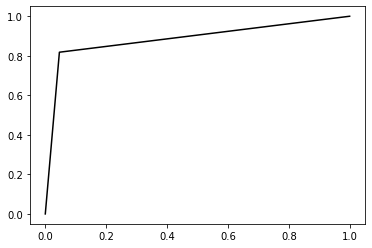

In [248]:
predictions = model.predict(X_test)

#print(predictions)

final_predictions = []
for x in predictions:
    if x < 0.5:
        final_predictions.append(0)
    else:
        final_predictions.append(1)
#print(final_predictions)
#print(Y_test)
print(np.mean(np.array(final_predictions) == np.array(Y_test)))
print(confusion_matrix(Y_test, final_predictions))
fpr, tpr, thresholds = roc_curve(Y_test, final_predictions)
print(fpr)
print(tpr)

plt.plot(fpr, tpr)

./iteration2/data_mini_exp.json
Loading data...
###################### Experiment 1 ##################


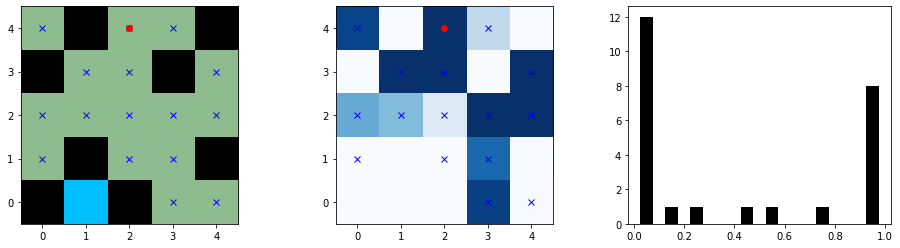

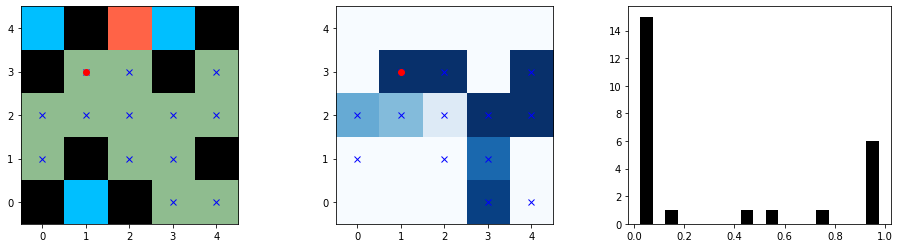

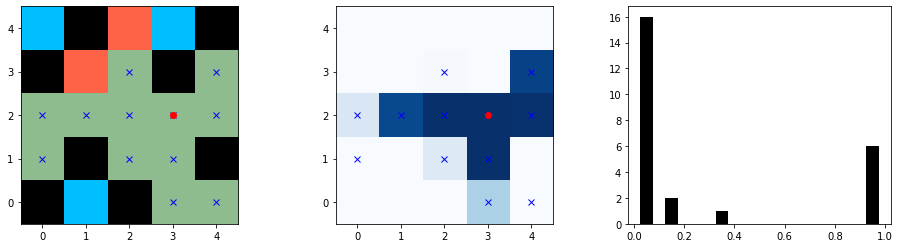

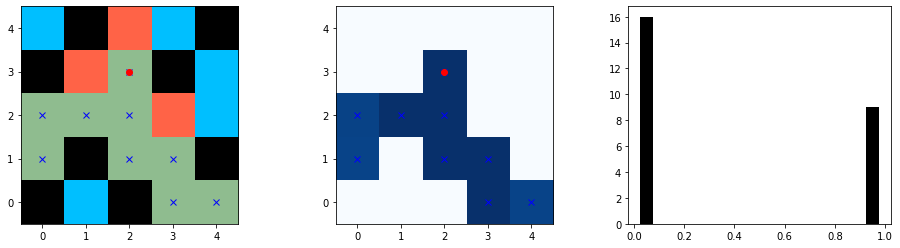

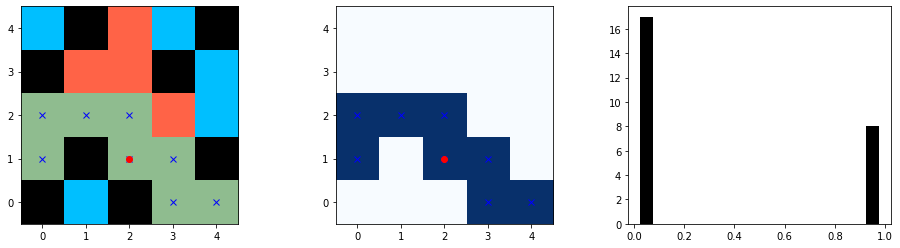

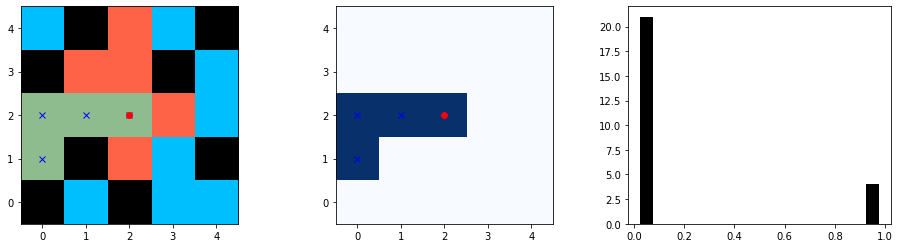

###################### Experiment 2 ##################


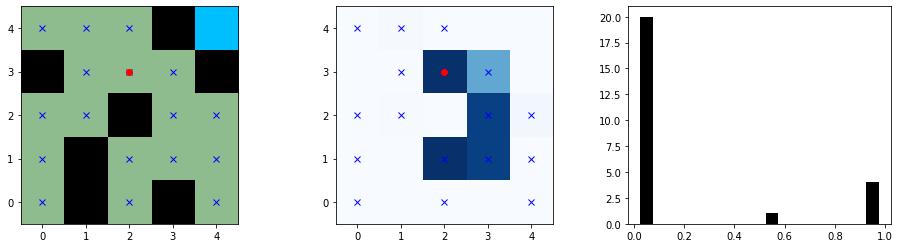

###################### Experiment 3 ##################


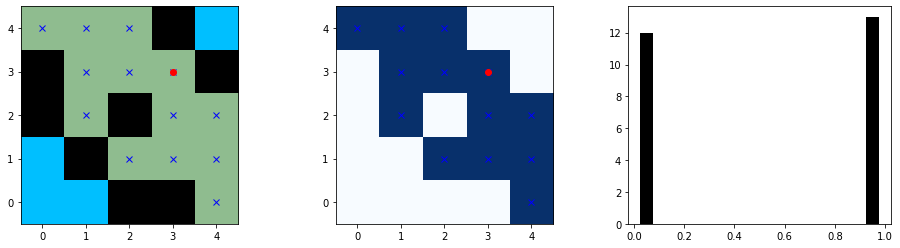

###################### Experiment 4 ##################


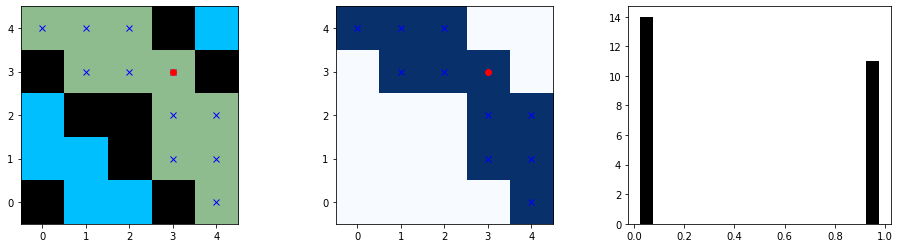

Done
./iteration3/data_mini_exp.json
Loading data...
###################### Experiment 1 ##################


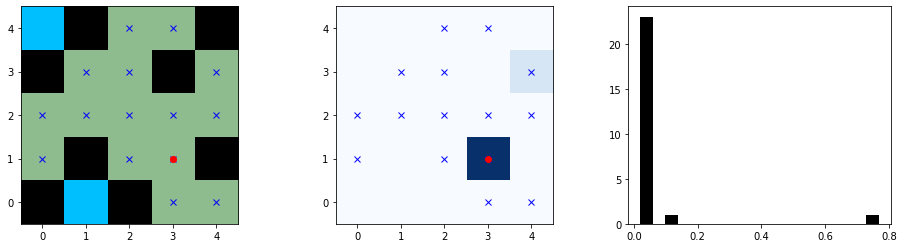

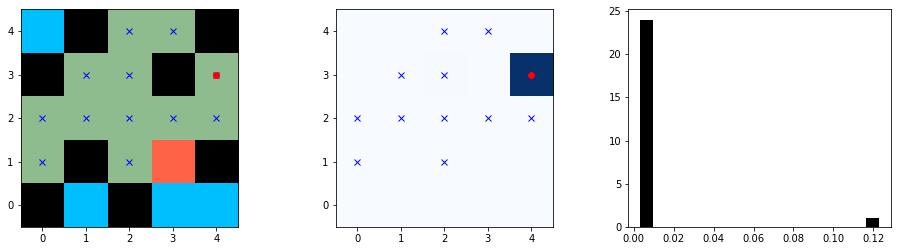

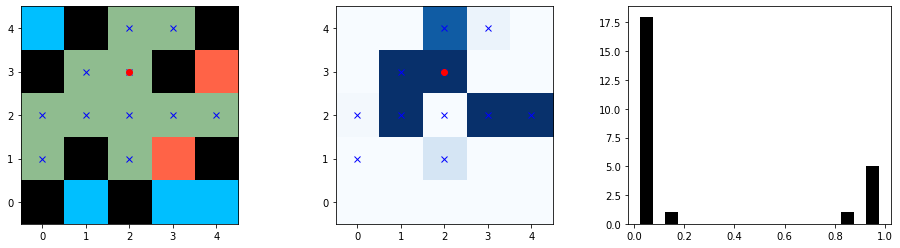

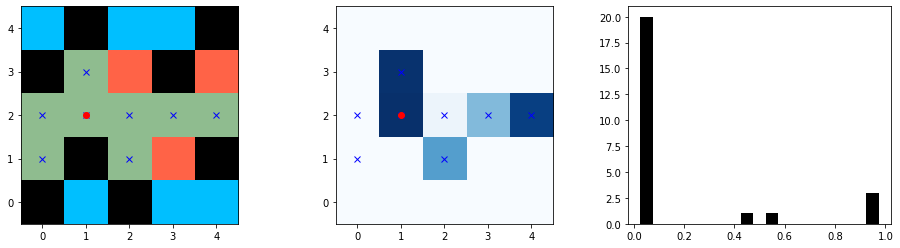

###################### Experiment 2 ##################


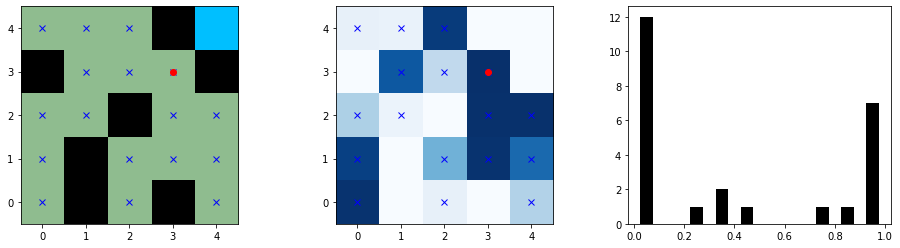

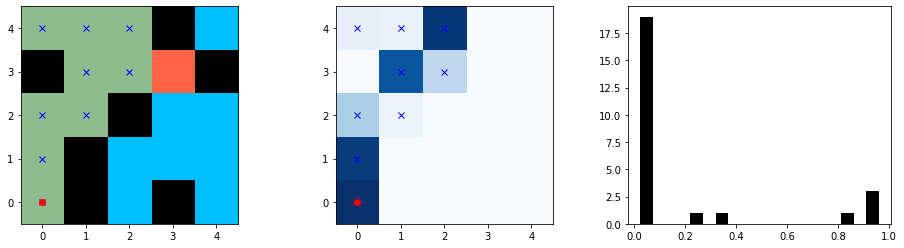

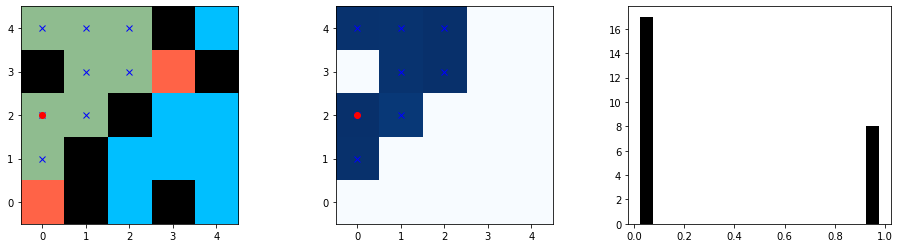

###################### Experiment 3 ##################


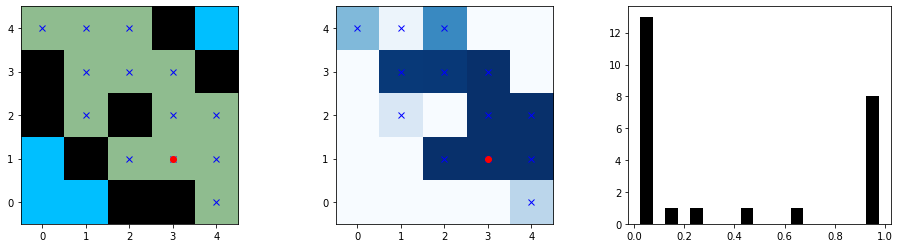

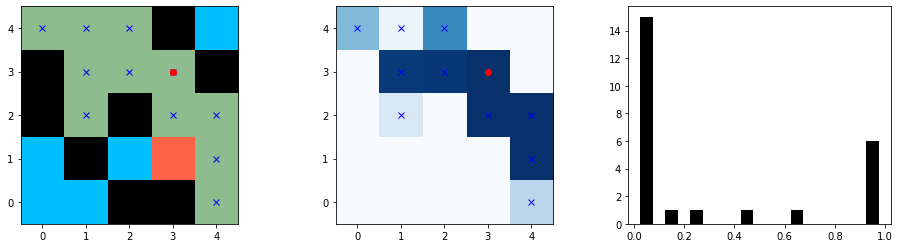

###################### Experiment 4 ##################


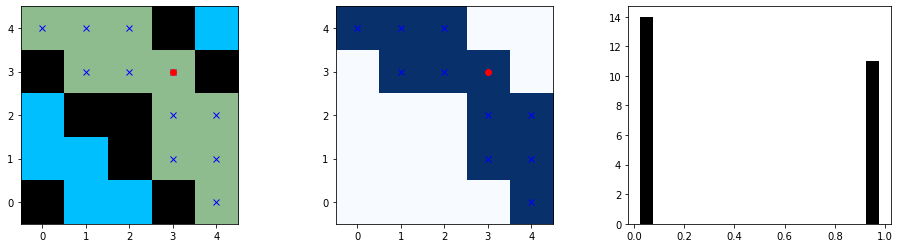

Done


In [131]:
flatui = ["black", "tomato", "deepskyblue", "darkseagreen"]
#flatui = 
sns.set_palette(flatui)
new_cmap = ListedColormap(flatui)
    

def plot_data(file_path):
    X1_train = []
    X2_train = []
    Y_train = []
    
    x_list = []
    
    print("Loading data...")
    try:
        with open(file_path) as json_file:
            json_data = json.load(json_file)
        skip = 0
        
        x = 0
        for key, value in json_data.items():
            #x += len(action)
                x += 1
            #if x/1 == 1:
                print("###################### Experiment "+str(x)+" ##################")
                for index in range(len(value)):
                    fig, axes = plt.subplots(1, 3)#,figsize=(10,5))
                    fig.set_figwidth(16)
                    axes[0].imshow(np.array(value[index]['board_state']), origin='lower', cmap=new_cmap)
                    array = np.zeros((5,5))
                    for a in value[index]['action_space']:
                        axes[0].plot(a['y'], a['x'], 'bx')
                        axes[1].plot(a['y'], a['x'], 'bx')
                        array[a['x']][a['y']] = a['prob']
                    axes[1].imshow(array, cmap='Blues', origin='lower')
                    axes[0].plot(value[index]['action']['y'], value[index]['action']['x'], 'ro')
                    axes[1].plot(value[index]['action']['y'], value[index]['action']['x'], 'ro')
                    #array = np.reshape(array, (25,))
                    axes[2].hist(array.flatten(), rwidth = 0.5)
                    #axes[2].set_ylim(8, 13)
                    #axes[2].set_xlim(0, 0.5)
                    plt.show()
                    #break
        
        print("Done")
    except Exception as e:
        print(e)
        
for i in range(2, 4):
    file_path = './iteration'+str(i)+'/data_mini_exp.json'
    print(file_path)
    plot_data(file_path)

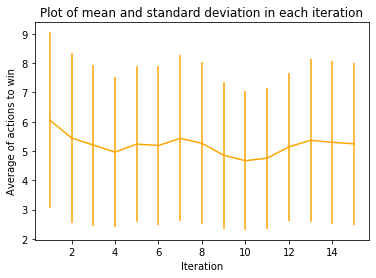

Text(0, 0.5, 'Average of actions to win')

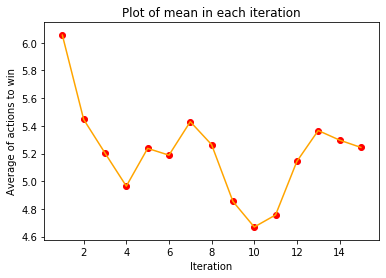

In [252]:
averages = []

stand_devs = []

for i in range(1, 16):
    file_path = './iteration'+str(i)+'/data_exp_1.json'

    with open(file_path) as json_file:
        json_data = json.load(json_file)
    
    x = []

    for key, value in json_data.items():
        x.append(len(value))
    
    
    file_path = './iteration'+str(i)+'/data_exp_2.json'

    with open(file_path) as json_file:
        json_data = json.load(json_file)

    for key, value in json_data.items():
        x.append(len(value))
    
    avg = sum(x)/1000
    std_dev = np.array(x).std()
    averages.append(avg)
    stand_devs.append(std_dev)
    #print(sum(x)/1000)

    #plt.hist(x, bins=50)
    #plt.show()
    
x = list(range(1, 16))
plt.errorbar(x, averages, yerr=stand_devs, color='orange')
plt.title("Plot of mean and standard deviation in each iteration")
plt.xlabel("Iteration")
plt.ylabel("Average of actions to win")
plt.show()
plt.plot(x, averages, color='orange')
plt.scatter(x, averages, color='red')
plt.title("Plot of mean in each iteration")
plt.xlabel("Iteration")
plt.ylabel("Average of actions to win")
#plt.scatter(x, stand_devs)